In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# =========================
# Paths
# =========================
DATA_DIR = r"D:\Skin-type.v10i.folder"        # current dataset with train/valid/test
SPLIT_DIR = r"D:\Skin-type.v10i.folder\Resplit_Data"   # new output folder

# Classes
classes = ['dry', 'normal', 'oily']

# =========================
# Step 1: Gather all images + labels
# =========================
all_images, all_labels = [], []

for split in ['train', 'valid', 'test']:
    for cls in classes:
        class_path = os.path.join(DATA_DIR, split, cls)
        for fname in os.listdir(class_path):
            src = os.path.join(class_path, fname)
            all_images.append(src)
            all_labels.append(cls)

print(f"✅ Collected {len(all_images)} images across {len(classes)} classes")

# =========================
# Step 2: Stratified split (70/15/15)
# =========================
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels,
    train_size=0.7,
    random_state=42,
    stratify=all_labels
)

val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels,
    test_size=0.5,  # split remaining 30% equally → 15% val, 15% test
    random_state=42,
    stratify=temp_labels
)

# =========================
# Step 3: Copy into new split folders
# =========================
def copy_images(image_list, label_list, split_name):
    for img, lbl in zip(image_list, label_list):
        dst_dir = os.path.join(SPLIT_DIR, split_name, lbl)
        os.makedirs(dst_dir, exist_ok=True)
        dst = os.path.join(dst_dir, os.path.basename(img))
        if not os.path.exists(dst):
            shutil.copy(img, dst)

copy_images(train_imgs, train_labels, "train")
copy_images(val_imgs, val_labels, "valid")
copy_images(test_imgs, test_labels, "test")

print("✅ Stratified resplit (70/15/15) complete")


✅ Collected 52848 images across 3 classes
✅ Stratified resplit (70/15/15) complete


In [14]:
import os

# =========================
# Paths
# =========================
DATA_DIR = r"D:\Skin-type.v10i.folder\Resplit_Data"

# Subfolders
train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "valid")
test_dir  = os.path.join(DATA_DIR, "test")

# Classes
classes = ['dry', 'normal', 'oily']

# =========================
# Check dataset structure
# =========================
print("✅ Dataset structure:")
for split in ["train", "valid", "test"]:
    split_path = os.path.join(DATA_DIR, split)
    print(f"\n📂 {split} ({split_path})")
    for cls in classes:
        class_path = os.path.join(split_path, cls)
        if os.path.exists(class_path):
            n_images = len(os.listdir(class_path))
            print(f"   {cls}: {n_images} images")
        else:
            print(f"   ⚠️ Missing class folder: {cls}")


✅ Dataset structure:

📂 train (D:\Skin-type.v10i.folder\Resplit_Data\train)
   dry: 10940 images
   normal: 14885 images
   oily: 11168 images

📂 valid (D:\Skin-type.v10i.folder\Resplit_Data\valid)
   dry: 2344 images
   normal: 3190 images
   oily: 2393 images

📂 test (D:\Skin-type.v10i.folder\Resplit_Data\test)
   dry: 2344 images
   normal: 3190 images
   oily: 2394 images


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

# =========================
# Paths & Parameters
# =========================
DATA_DIR = r"D:\Skin-type.v10i.folder\Resplit_Data"

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "valid")
test_dir  = os.path.join(DATA_DIR, "test")

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4   # ✅ your dataset has 4 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

print("✅ Paths set:")
print("Train folder:", train_dir)
print("Validation folder:", val_dir)
print("Test folder:", test_dir)
print("Device:", DEVICE)


✅ Paths set:
Train folder: D:\Skin-type.v10i.folder\Resplit_Data\train
Validation folder: D:\Skin-type.v10i.folder\Resplit_Data\valid
Test folder: D:\Skin-type.v10i.folder\Resplit_Data\test
Device: cpu


In [2]:
# =========================
# Data Augmentation (Training)
# =========================
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =========================
# Data Preprocessing (Validation/Test)
# =========================
transform_val_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [3]:
# =========================
# Load Datasets
# =========================
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform_train)
val_dataset   = datasets.ImageFolder(root=os.path.join(DATA_DIR, "valid"), transform=transform_val_test)
test_dataset  = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform_val_test)

class_names = train_dataset.classes
print("✅ Classes:", class_names)

# =========================
# Handle Class Imbalance with WeightedRandomSampler
# =========================
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", dict(zip(class_names, class_counts)))

class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_dataset.targets]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("✅ DataLoaders ready")


✅ Classes: ['dry', 'normal', 'oily']
Class counts: {'dry': 10940, 'normal': 14885, 'oily': 11168}
✅ DataLoaders ready


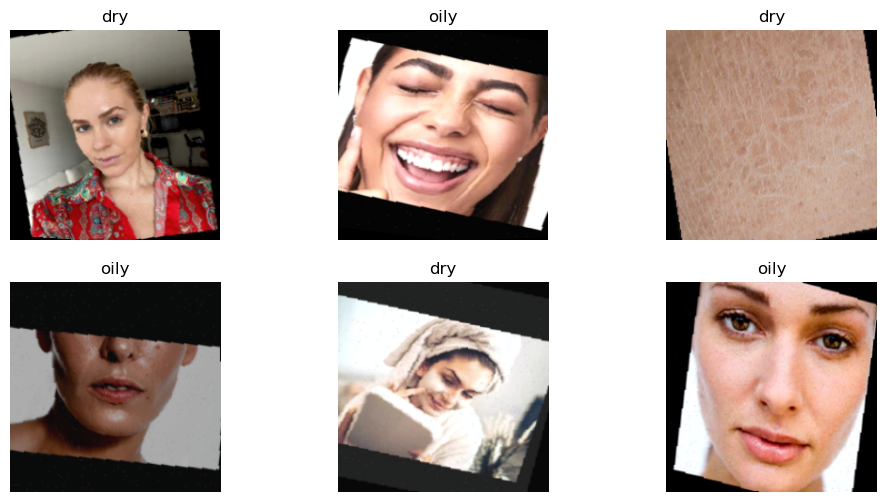

In [4]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

# Show a few random images
images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i], title=class_names[labels[i].item()])
plt.show()


In [5]:
# =========================
# Load Pretrained ResNet50
# =========================
model = models.resnet50(pretrained=True)

# Fine-tune last block + fc only
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final layer with Dropout + Linear
model.fc = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)

model = model.to(DEVICE)
print("✅ Model ready")


C:\Users\Eman\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Eman\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model ready


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# Use ReduceLROnPlateau to adjust learning rate dynamically
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [7]:
def train_model_with_early_stop(model, train_loader, val_loader, max_epochs=EPOCHS, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} - Training"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} - Validation"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}% | Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")

        # Step scheduler
        scheduler.step(val_loss_avg)

        # Early stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⚠️ Early stopping triggered")
                break

    # Load best model
    model.load_state_dict(torch.load("best_model.pth"))
    return model


In [8]:
model = train_model_with_early_stop(model, train_loader, val_loader, max_epochs=EPOCHS, patience=5)


Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [18:23<00:00,  4.45s/it]


Epoch 1/10 | Train Loss: 0.3879, Train Acc: 84.39% | Val Loss: 0.1563, Val Acc: 94.71%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [19:37<00:00,  4.75s/it]


Epoch 2/10 | Train Loss: 0.1279, Train Acc: 95.63% | Val Loss: 0.2525, Val Acc: 91.69%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [18:26<00:00,  4.46s/it]


Epoch 3/10 | Train Loss: 0.0910, Train Acc: 96.82% | Val Loss: 0.1042, Val Acc: 96.19%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [18:04<00:00,  4.37s/it]


Epoch 4/10 | Train Loss: 0.0758, Train Acc: 97.30% | Val Loss: 0.0732, Val Acc: 97.77%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [20:12<00:00,  4.89s/it]


Epoch 5/10 | Train Loss: 0.0670, Train Acc: 97.58% | Val Loss: 0.0749, Val Acc: 97.92%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [19:53<00:00,  4.81s/it]


Epoch 6/10 | Train Loss: 0.0583, Train Acc: 97.88% | Val Loss: 0.0627, Val Acc: 98.31%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [17:45<00:00,  4.30s/it]


Epoch 7/10 | Train Loss: 0.0531, Train Acc: 98.08% | Val Loss: 0.0906, Val Acc: 97.17%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [12:03<00:00,  2.92s/it]


Epoch 8/10 | Train Loss: 0.0485, Train Acc: 98.25% | Val Loss: 0.0562, Val Acc: 98.27%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 248/248 [12:06<00:00,  2.93s/it]


Epoch 9/10 | Train Loss: 0.0467, Train Acc: 98.23% | Val Loss: 0.0650, Val Acc: 98.41%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 248/248 [12:04<00:00,  2.92s/it]


Epoch 10/10 | Train Loss: 0.0456, Train Acc: 98.27% | Val Loss: 0.0604, Val Acc: 98.20%


In [9]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Testing: 100%|███████████████████████████████████████████████████████████████████████| 248/248 [11:59<00:00,  2.90s/it]

✅ Test Accuracy: 98.31%


Testing (Detailed): 100%|████████████████████████████████████████████████████████████| 248/248 [10:26<00:00,  2.53s/it]


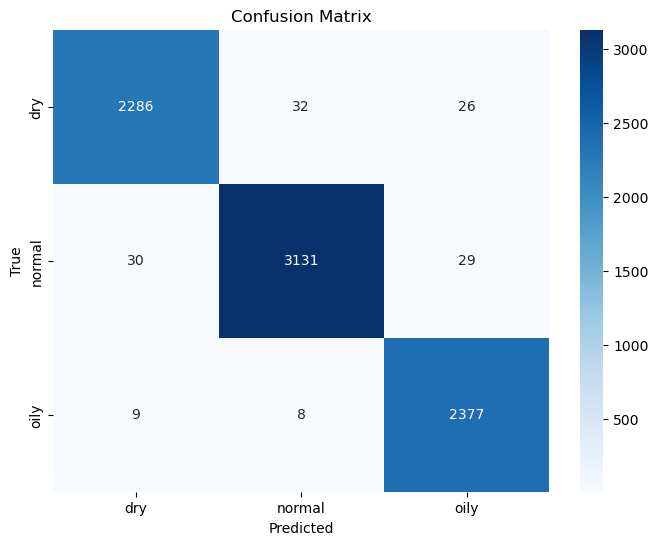

Classification Report:
              precision    recall  f1-score   support

         dry       0.98      0.98      0.98      2344
      normal       0.99      0.98      0.98      3190
        oily       0.98      0.99      0.99      2394

    accuracy                           0.98      7928
   macro avg       0.98      0.98      0.98      7928
weighted avg       0.98      0.98      0.98      7928



In [10]:
# =========================
# Confusion Matrix & Classification Report
# =========================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_detailed(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing (Detailed)"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Run detailed evaluation
evaluate_detailed(model, test_loader, class_names)


In [11]:
import torch
import os

# Path to save the model
MODEL_PATH = "D:/Grad_project/Models/resnet50984_skin_model.pth"

# Save the model's state_dict (recommended way)
torch.save(model.state_dict(), MODEL_PATH)

print(f"✅ Model saved at {MODEL_PATH}")


✅ Model saved at D:/Grad_project/Models/resnet50984_skin_model.pth
